# 주제 : 사진에서 사람영역만 구분해보기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제의 데이터는 protrait 데이터로 유명한 PFCN dataset을 이용합니다.
  ![PFCN dataset](https://www.researchgate.net/profile/Dawei_Li49/publication/334417334/figure/fig4/AS:832930272276492@1575597460956/Sample-images-from-the-PFCN-dataset.jpg)

     위의 이미지는 다음과 같은 것을 보여줍니다.  
    - 800x600의 사람 portrait 이미지  
     - ?????.png  
    - 사람 영역에 대한 흑백 portrait 이미지
     - ?????_matte.png
    - pfcn_original
     - 원본 800x600 이미지들
    - pfcn_small
     - colab용 100x75 이미지들



- 데이터 출처: 
 - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)
 - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)
 - [pfcn_original](https://onedrive.live.com/?authkey=%21ADkS4V32BUmspOg&cid=F5111408123B1D9C&id=F5111408123B1D9C%2115035&parId=F5111408123B1D9C%2115033&action=locate)

## 최종 목표

    - 작게 줄인 PFCN 데이터를 이용하여 사람 영역 추출
    - 코렙에 구글 drive 연동
    - 큰 사진을 작게 줄이기
    - 이미지에 대한 오토인코더식 접근 방법

- 출제자 : 손근영 강사
---


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## Step 1. 도입전 기본 처리

### 문제 1. 구글 drive와 colab 연동하기

https://onedrive.live.com/?authkey=%21ADkS4V32BUmspOg&cid=F5111408123B1D9C&id=F5111408123B1D9C%2115035&parId=F5111408123B1D9C%2115033&action=locate

In [2]:
import torch

# GPU 사용 가능 여부 확인
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.1.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-14.0-arm64-arm-64bit


### 문제 2. pfcn 데이터 살펴보기

In [3]:
# 데이터를 np array로 training에서 사람 이미지 한장과 영역 이미지 한장을 불러오는 코드를 작성해주세요. (x, y로 변수 대입)

import imageio

x = imageio.imread('datasets/pfcn_original/training/00001.png')

y = imageio.imread('datasets/pfcn_original/training/00001_matte.png')



### 문제 3. x와 y의 shape을 출력해보세요.

In [4]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.

print(x.shape)
print(y.shape)



(800, 600, 3)
(800, 600)


### 문제 4. x, y를 각각 plt를 통하여 출력하세요.

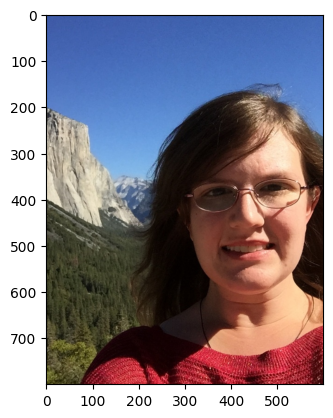

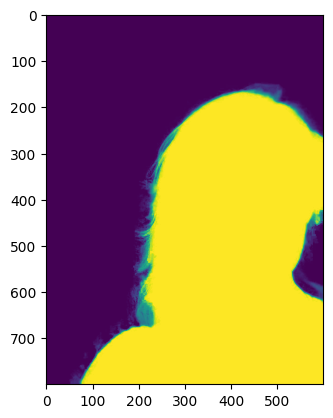

In [5]:
# x, y를 plt를 이용하여 출력하는 코드를 작성해보세요.
plt.imshow(x)
plt.show()

plt.imshow(y)
plt.show()

### 문제 5. (800, 600)의 의미지는 colab에서 돌리기에 너무 큽니다. (100, 75)로 이미지를 줄여보세요

In [6]:
# x와 y를 각각 (800, 600, 3) -> (100, 75, 3), (800, 600) -> (100, 75)로 줄이고 plt에서 확인하는 코드를 작성하세요.

from skimage.transform import resize

x1 = resize(x, output_shape=(100, 75))
y1 = resize(y, output_shape=(100, 75))

print(x1.shape)
print(y1.shape)


(100, 75, 3)
(100, 75)


In [7]:
import os
import imageio
import numpy as np

# 이미지 파일이 있는 폴더 경로
folder_path = 'datasets/pfcn_original/training'

# 이미지 파일 목록을 얻습니다.
image_files = os.listdir(folder_path)

# train_images와 train_mattes 배열을 초기화합니다.
train_images = []
train_mattes = []

# 이미지 파일을 순회하면서 처리합니다.
for image_file in image_files:
    if image_file.endswith('.png'):
        # 이미지 파일 이름에서 '_matte'가 포함된 파일이 있는지 확인합니다.
        if '_matte' in image_file:
            matte_path = os.path.join(folder_path, image_file)
            image_id = image_file.split('_matte')[0]
            image_path = os.path.join(folder_path, f'{image_id}.png')
            
            # 이미지와 매트 이미지를 로드합니다.
            image = imageio.imread(image_path)
            matte = imageio.imread(matte_path)
            
            # train_images와 train_mattes 배열에 추가합니다.
            train_images.append(image)
            train_mattes.append(matte)

# NumPy 배열로 변환합니다.
train_images = np.array(train_images)
train_mattes = np.array(train_mattes)

# train_images와 train_mattes의 shape를 확인합니다.
print("train_images shape:", train_images.shape)
print("train_mattes shape:", train_mattes.shape)


train_images shape: (1700, 800, 600, 3)
train_mattes shape: (1700, 800, 600)


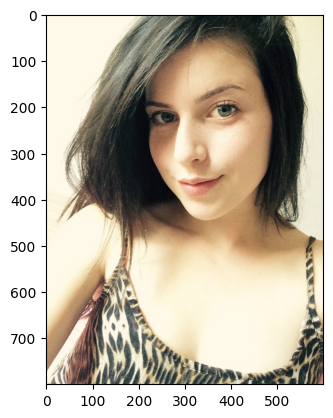

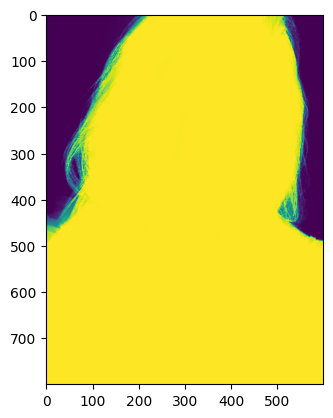

In [8]:
plt.imshow(train_images[100])
plt.show()
plt.imshow(train_mattes[100])
plt.show()

In [9]:
import os
import imageio
import numpy as np

# 이미지 파일이 있는 폴더 경로
folder_path = 'datasets/pfcn_original/testing'

# 이미지 파일 목록을 얻습니다.
image_files = os.listdir(folder_path)

# train_images와 train_mattes 배열을 초기화합니다.
test_images = []
test_mattes = []

# 이미지 파일을 순회하면서 처리합니다.
for image_file in image_files:
    if image_file.endswith('.png'):
        # 이미지 파일 이름에서 '_matte'가 포함된 파일이 있는지 확인합니다.
        if '_matte' in image_file:
            matte_path = os.path.join(folder_path, image_file)
            image_id = image_file.split('_matte')[0]
            image_path = os.path.join(folder_path, f'{image_id}.png')
            
            # 이미지와 매트 이미지를 로드합니다.
            image = imageio.imread(image_path)
            matte = imageio.imread(matte_path)
            
            # train_images와 train_mattes 배열에 추가합니다.
            test_images.append(image)
            test_mattes.append(matte)

# NumPy 배열로 변환합니다.
test_images = np.array(test_images)
test_mattes = np.array(test_mattes)

# train_images와 train_mattes의 shape를 확인합니다.
print("test_images shape:", test_images.shape)
print("test_mattes shape:", test_mattes.shape)


test_images shape: (300, 800, 600, 3)
test_mattes shape: (300, 800, 600)


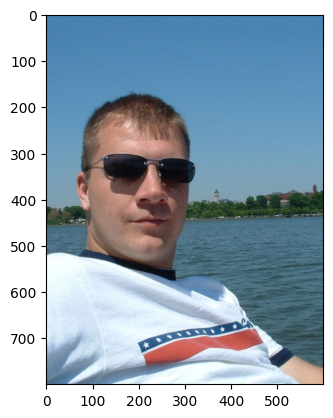

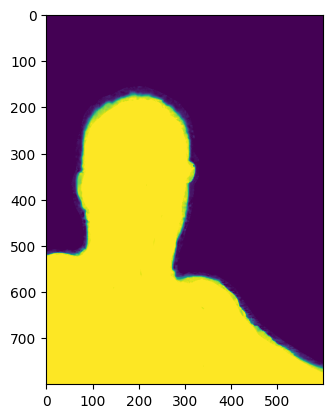

In [10]:
plt.imshow(test_images[2])
plt.show()
plt.imshow(test_mattes[2])
plt.show()

### 문제 6 pfcn_small.npz 데이터에서 학습, 테스트 데이터를 로드하세요.

In [11]:
# 주어진 링크에서 pfcn_small.npz를 다운 받으세요.
#https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing

# !gdown --id 1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl

In [12]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.

pfcn_data = np.load('datasets/pfcn_small.npz')
for i in pfcn_data:
    print(i)

train_images_small, train_mattes_small = pfcn_data['train_images'], pfcn_data['train_mattes']
test_images_small, test_mattes_small = pfcn_data['test_images'], pfcn_data['test_mattes']

print(train_images_small.shape)
print(train_mattes_small.shape)
print(test_images_small.shape)
print(test_mattes_small.shape)

train_images
test_images
train_mattes
test_mattes
(1700, 100, 75, 3)
(1700, 100, 75)
(300, 100, 75, 3)
(300, 100, 75)


### 문제 7. train_images에서 0이 아닌 값들을 출력해보세요.

In [13]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요.

print("train_images shape:", train_images.shape)
print("train_mattes shape:", train_mattes.shape)
print("test_images shape:", test_images.shape)
print("test_mattes shape:", test_mattes.shape)

print(train_images[train_images != 0][:10])
print(train_mattes[train_mattes != 0][:10])
print(test_images[test_images != 0][:10])
print(test_mattes[test_mattes != 0][:10])


train_images shape: (1700, 800, 600, 3)
train_mattes shape: (1700, 800, 600)
test_images shape: (300, 800, 600, 3)
test_mattes shape: (300, 800, 600)
[172 166 144 171 165 143 172 164 143 172]
[1 1 1 1 2 2 2 2 2 2]
[222 223 215 220 221 213 221 222 214 223]
[ 6  6 23 23 24 24 21 20 22 34]


### 문제 8. train_images의 dtype을 출력해보세요.

In [14]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.

print(train_images.dtype)
print(train_mattes.dtype)
print(test_images.dtype)
print(test_mattes.dtype)

uint8
uint8
uint8
uint8


## Step 2. 전처리

### 문제 9. images/mattes 이미지 데이터의 범위 확인

In [15]:
#  test_images, test_mattes의 shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성하세요.

print(test_images.shape, test_images.dtype, test_images[test_images != 0])
print(test_mattes.shape, test_mattes.dtype, test_mattes[test_mattes != 0])

(300, 800, 600, 3) uint8 [222 223 215 ... 103  80  62]
(300, 800, 600) uint8 [  6   6  23 ... 255 255 255]


### 문제 10. images/mattes 이미지 데이터의 최소/최대값을 출력

In [16]:
# train/test 전체 데이터에서 각 images, mattes의 min, max를 출력하는 코드를 작성하세요.

print(train_images.max(), train_images.min())
print(train_mattes.max(), train_mattes.min())

print(test_images.max(), test_images.min())
print(test_mattes.max(), test_mattes.min())

255 0
255 0
255 0
255 0


### 문제 11. mattes의 shape을 (배치, 100, 75, 3)에서 (배치, 100, 75, 1)으로 변경하세요.

In [17]:
# (배치, 100, 75,3)의 흑백 shape을 (배치, 100, 75, 1)의 흑백 shape의 영역으로 축소하는 코드를 추가하세요.
from skimage import color
train_mattes_small = np.array([color.gray2rgb(img) for img in train_mattes_small])
test_mattes_small = np.array([color.gray2rgb(img) for img in test_mattes_small])
print(train_mattes_small.shape, test_mattes_small.shape)

train_mattes_small = np.array([color.rgb2gray(img).reshape(100, 75, 1) for img in train_mattes_small])
test_mattes_small = np.array([color.rgb2gray(img).reshape(100, 75, 1) for img in test_mattes_small])
print(train_mattes_small.shape, test_mattes_small.shape)


(1700, 100, 75, 3) (300, 100, 75, 3)
(1700, 100, 75, 1) (300, 100, 75, 1)


In [18]:
train_images.shape

(1700, 800, 600, 3)

In [19]:
train_mattes =  train_mattes.reshape(-1, 800, 600, 1)
test_mattes =  test_mattes.reshape(-1, 800, 600, 1)

print(train_mattes[0].shape)
print(test_mattes.shape)

(800, 600, 1)
(300, 800, 600, 1)


## Step 3. 시각화 방법

### 문제 12. train_image의 이미지를 5장 획득하여 (5, 100, 75, 3)의 shape을 출력하세요.

In [20]:
# (배치, 100, 75, 3)인 train_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.
train_images[:5].shape

(5, 800, 600, 3)

### 문제 13. 획득한 5장의 의미지를 (100, 75 * 5, 3)의 shape으로 변경해보세요.

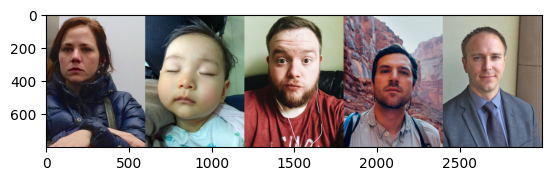

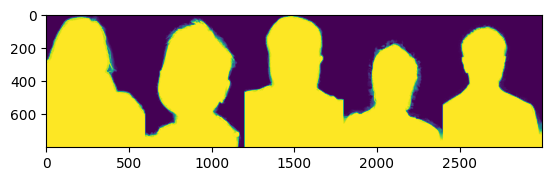

In [21]:
# np.hstack은 height 방향의 배열을 풀어서 width 방향으로 연결해줍니다.
# 해당 기능을 쓰면 (height, image_height, image_width, color)의 shape을 (image_height, image_width * height, color)으로 바꿔 줄 수 있습니다.
# 코드를 작성해보세요.

plt.imshow(np.hstack(train_images[:5]))
plt.show()
plt.imshow(np.hstack(train_mattes[:5]))
plt.show()

In [22]:
# transpose는 tensor의 axis를 섞는 기능을 합니다.
# 해당 기능을 이용해서 (100, 375, 3)을 작성하는 코드를 작성해보세요.

print(train_images.shape, train_mattes.shape)

print(train_images[:5].transpose(1, 0, 2, 3).reshape(800, -1, 3).shape)
print(train_mattes[:5].transpose(1, 0, 2, 3).reshape(800, -1, 1).shape)

(1700, 800, 600, 3) (1700, 800, 600, 1)
(800, 3000, 3)
(800, 3000, 1)


### 문제 14. (100, 375, 3)이 된 tensor를 plt로 출력해보세요.

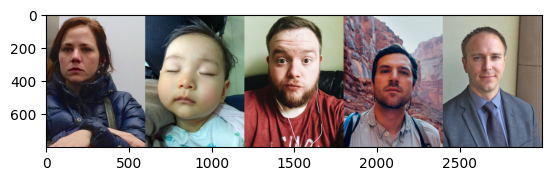

In [23]:
# (28, 140, 3)의 이미지를 plt로 출력해보세요.

plt.imshow(train_images[:5].transpose(1, 0, 2, 3).reshape(800, -1, 3))
plt.show()

### 문제 15. mettes도 (100, 375)으로 plt로 출력해보세요.

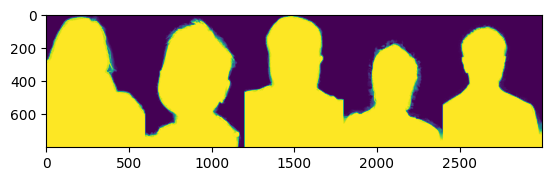

In [24]:
# (28, 140, 1)의 이미지를 plt로 출력해보세요.

plt.imshow(train_mattes[:5].transpose(1, 0, 2, 3).reshape(800, -1, 1))
plt.show()


## Step 4. AE 모델링

### 문제 16. 해당 학습셋을 처리하는 이미지 segmentation 모델을 작성하세요.

In [25]:
print(train_images.shape, train_mattes.shape)

(1700, 800, 600, 3) (1700, 800, 600, 1)


In [26]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose, UpSampling2D, Input, Reshape

def ae_like_original():
    inputs = Input(shape = (800, 600, 3))
    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(inputs)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 512, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Flatten()(x)
    latent_vector = Dense(units = 50)(x)

    x = Dense((25 * 20 * 512))(latent_vector)
    x = Reshape((25, 20, 512))(x)
    x = Conv2DTranspose(filters = 512, kernel_size = 3, strides = (2, 2), padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 256, kernel_size = 3, strides = (2, 3), padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 128, kernel_size = 3, strides = (2, 5), padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = (2, 1), padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = (2, 1), padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 1, kernel_size = 3, strides = (1, 1), padding = 'same', activation = 'sigmoid')(x)
    model = Model(inputs, x)
    return model


model_original = ae_like_original()
model_original.summary()


2023-10-12 19:18:31.060756: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-12 19:18:31.060786: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-12 19:18:31.060842: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-12 19:18:31.061245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-12 19:18:31.061599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 800, 600, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 300, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 150, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 75, 128)      73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 38, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 19, 512)       1180160   
                                                                 
 flatten (Flatten)           (None, 243200)            0     

In [27]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose, UpSampling2D, Input, Reshape

def ae_like():
    inputs = Input(shape = (100, 75, 3))
    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(inputs)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Flatten()(x)
    latent_vector = Dense(units = 10)(x)

    x = Dense(13 * 10 * 128)(latent_vector)
    x = Reshape((13, 10, 128))(x)

    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2D(128, (2, 2), (1, 1), activation = 'relu', padding = 'valid')(x)

    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2D(64, (1, 1), (1, 1), activation = 'relu', padding = 'valid')(x)

    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2D(32, (1, 2), (1, 1), activation = 'relu', padding = 'valid')(x)

    x = Conv2D(1, (1, 1), (1, 1), activation = 'sigmoid')(x)
    
    model = Model(inputs, x)
    return model


In [28]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Input

def ae_like2():
    inputs = Input(shape = (100, 75, 3))
    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(inputs)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Flatten()(x)
    latent_vector = Dense(units = 10)(x)

    x = Dense(13 * 10 * 128)(latent_vector)
    x = Reshape((13, 10, 128))(x)

    x = Conv2DTranspose(filters = 128, kernel_size=3, strides=(2,2), padding = 'same', activation='relu')(x)
    x = Conv2DTranspose(filters = 64, kernel_size=3, strides=(2,2), padding = 'same', activation='relu')(x)
    x = Conv2DTranspose(filters = 32, kernel_size=3, strides=(2,2), padding = 'same', activation='relu')(x)


    model = Model(inputs, x)
    return model



model_test = ae_like2()
model_test.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 75, 3)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 38, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 19, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 10, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 16640)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                166410    
                                                                 
 dense_3 (Dense)             (None, 16640)             1830

### 문제 17. 모델을 할당 받고 서머리를 출력해보세요.

In [29]:
# ae_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.

model = ae_like()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 75, 3)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 38, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 19, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 10, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 16640)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                166410    
                                                                 
 dense_5 (Dense)             (None, 16640)             1830

### 문제 18. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [30]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.

model.compile(loss='mse', optimizer = 'adam', metrics = ['accuracy'])
model_original.compile(loss='mae', optimizer = 'adam', metrics = ['accuracy'])

### 문제 19. 만든 모델에 train_images를 학습시켜 보세요.

In [31]:
# ea_original = model_original.fit(
#     train_images,
#     train_mattes,
#     validation_data = (
#         test_images,
#         test_mattes
#     ),
    
#     epochs = 25,
#     batch_size = 128,
#     verbose = 1
# )

In [32]:
# train_images 학습시키고 25 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
ea_hist = model.fit(
    train_images_small,
    train_mattes_small,
    validation_data = (
        test_images_small,
        test_mattes_small
    ),
    
    epochs = 25,
    batch_size = 128,
    verbose = 1
)

Epoch 1/25


2023-10-12 19:18:35.249150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.7201

2023-10-12 19:18:44.244400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 12s 524ms/step - loss: 0.1685 - accuracy: 0.7201 - val_loss: 0.1299 - val_accuracy: 0.7594
Epoch 2/25
14/14 [==============================] - 3s 233ms/step - loss: 0.1289 - accuracy: 0.7617 - val_loss: 0.1266 - val_accuracy: 0.7618
Epoch 3/25
14/14 [==============================] - 3s 226ms/step - loss: 0.1273 - accuracy: 0.7625 - val_loss: 0.1257 - val_accuracy: 0.7624
Epoch 4/25
14/14 [==============================] - 3s 234ms/step - loss: 0.1261 - accuracy: 0.7630 - val_loss: 0.1244 - val_accuracy: 0.7625
Epoch 5/25
14/14 [==============================] - 3s 232ms/step - loss: 0.1253 - accuracy: 0.7628 - val_loss: 0.1233 - val_accuracy: 0.7621
Epoch 6/25
14/14 [==============================] - 3s 232ms/step - loss: 0.1239 - accuracy: 0.7631 - val_loss: 0.1214 - val_accuracy: 0.7633
Epoch 7/25
14/14 [==============================] - 3s 226ms/step - loss: 0.1215 - accuracy: 0.7655 - val_loss: 0.1182 - val_accuracy: 0.7681
Epoch 8/25
14/14

### 문제 20. 학습 진행 사항을 plt으로 출력하세요.

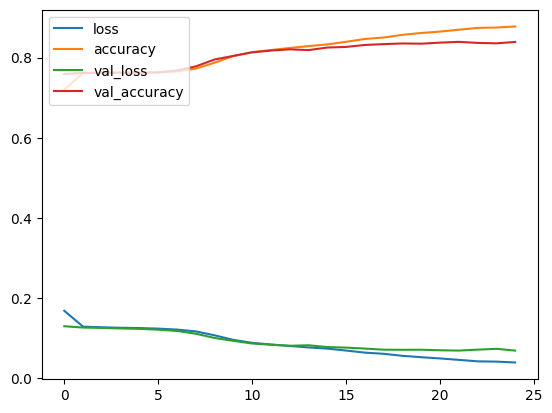

In [33]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.

plt.plot(ea_hist.history['loss'], label = 'loss')
plt.plot(ea_hist.history['accuracy'], label = 'accuracy')
plt.plot(ea_hist.history['val_loss'], label = 'val_loss')
plt.plot(ea_hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')
plt.show()

## Step 5. 결과 확인

### 문제 21. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

2023-10-12 19:20:03.817040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 483ms/step


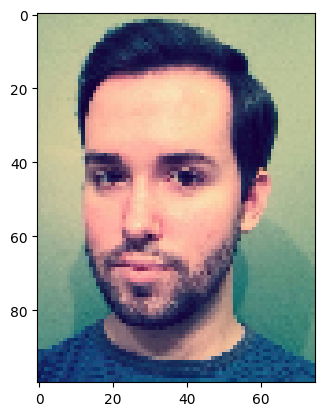

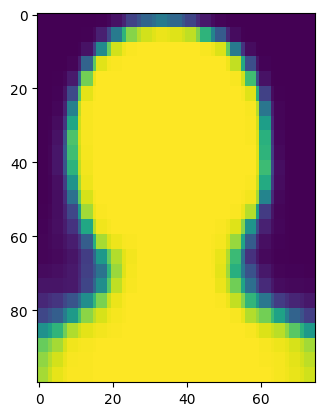

In [34]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(test_images_small[1:2])

plt.imshow(test_images_small[1])
plt.show()
plt.imshow(res[0])
plt.show()

### 문제 22. res, test_mattes[1]를 width 방향으로 결합하여 plt로 출력하세요.

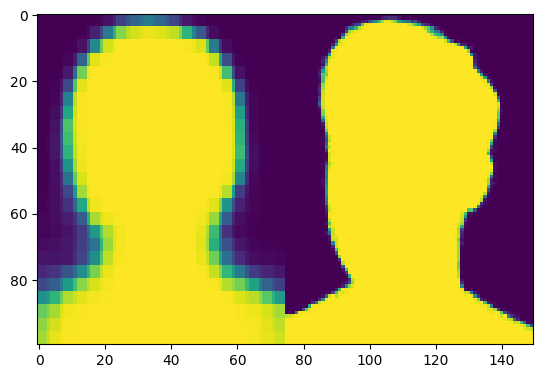

In [35]:
# res, test_mattes[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.

plt.imshow(np.concatenate([res[0], test_mattes_small[1]], axis = 1))
plt.show()

### 문제 23. res에 0.5의 값을 기준으로 0과 1로 2원화 시키고 다시 문제 22처럼 출력해보세요.

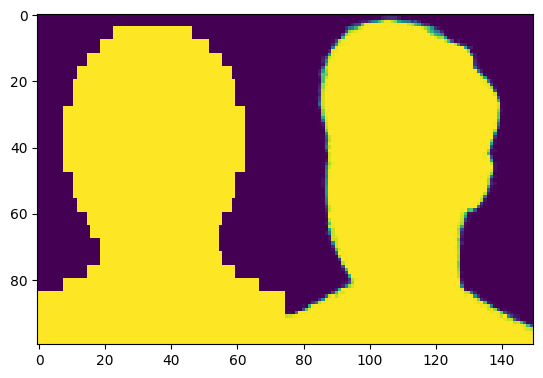

In [36]:
# res를 0.5기준으로 0,1의 값으로 이원화 시킨 뒤 문제 22처럼 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([res[0] > 0.5, test_mattes_small[1]], axis = 1))
plt.show()

### 문제 24. 5장의 test_images를 모델에 넣은 뒤 결과를 문제 22 방식으로 비교하세요.

1/1 [==============================] - 0s 402ms/step


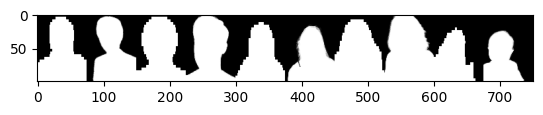

In [37]:
# 5장의 이미지를 모델에 넣고 결과를 22번과 같은 방식으로 비교하는 코드를 작성하세요

res_five = (model.predict(test_images_small[:5]) > 0.5).astype(np.float64)

plt.imshow(np.concatenate([res_five , test_mattes_small[:5]], axis = 2).transpose(1, 0, 2, 3).reshape(100, -1), cmap='gray')
plt.show()


### 문제 25. test_images[1]과 res를 곱한뒤 plt에 출력해보세요.

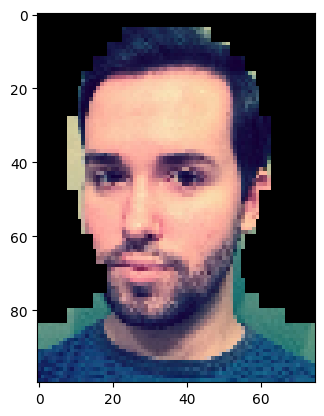

In [38]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지워보세요
plt.imshow(res_five[1].reshape(100, 75, 1) * test_images_small[1])
plt.show()


## Step 6. U-net 모델링

### 문제 26. 해당 학습셋을 처리하는 이미지 segmentation 모델을 작성하세요.

In [39]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.

from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
    x = Conv2D(filters=channel, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=channel, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x



def unet_like():
    inputs = Input(shape=(100, 75, 3))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(pool_size=(2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(pool_size=(2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(pool_size=(2, 2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(filters = 128, kernel_size=2, strides=2, output_padding=(0, 1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(filters = 64, kernel_size=2, strides=2, output_padding=(1, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(filters = 32, kernel_size=2, strides=2, output_padding=(0, 1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(filters = 16, kernel_size=2, strides=2, output_padding=(0, 1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(filters = 1, kernel_size=1, activation='sigmoid')(c9)


    model = Model(inputs, outputs)
    return model 



### 문제 27. 모델을 할당 받고 서머리를 출력해보세요.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100, 75, 3)]         0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 100, 75, 16)          448       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 100, 75, 16)          64        ['conv2d_15[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 100, 75, 16)          0         ['batch_normalization[0]

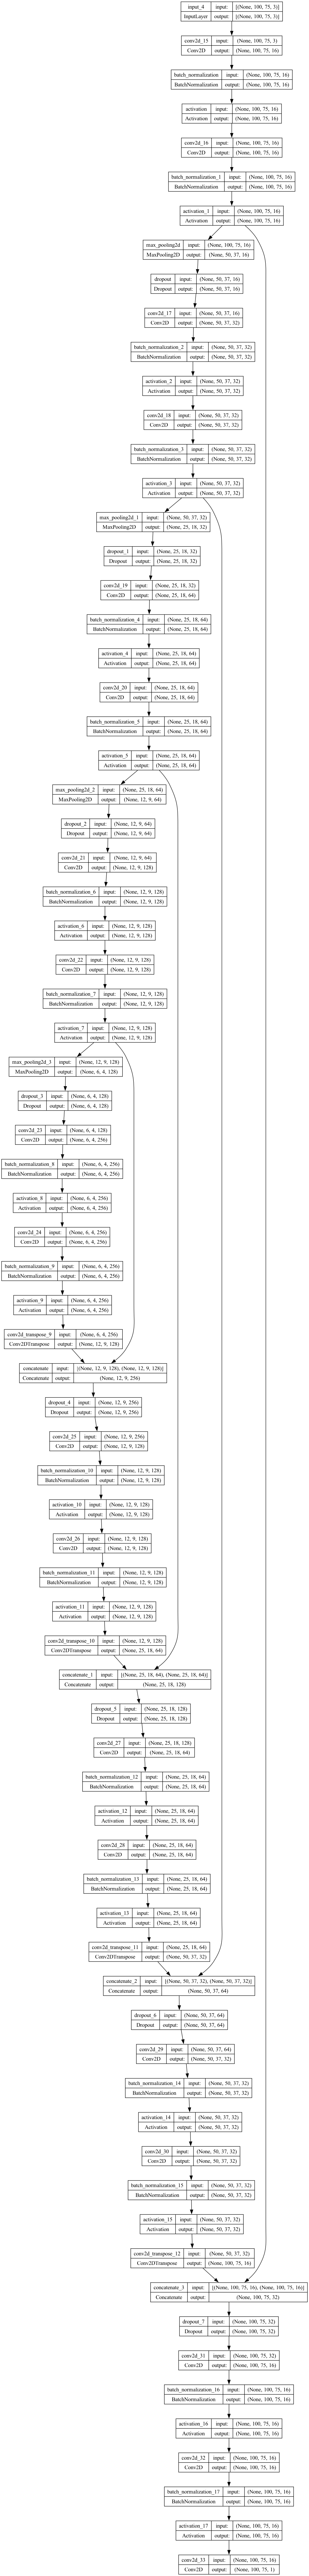

In [40]:
# unet_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.

model_unet = unet_like()
model_unet.summary()

from tensorflow.keras.utils import plot_model
plot_model(model_unet, to_file='/Users/mac/Dev/Study/DeepLearning/Practice/Lecture/DeepLearning_Exercise/Quiz/Part2/Part2_prac_backup/model_plot.png', show_shapes=True, show_layer_names=True)

### 문제 28. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [41]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.

model_unet.compile(loss = 'mse', optimizer = 'adam', metrics=['accuracy'])

### 문제 29. 만든 모델에 train_noisy_images를 학습시켜 보세요.

In [42]:
# train_images 학습시키고 25 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.

unet_hist = model_unet.fit(
    train_images_small,
    train_mattes_small,
    validation_data=(
        test_images_small,
        test_mattes_small
    ),
    epochs=25,
    batch_size = 128,
    verbose=1
)

Epoch 1/25


2023-10-12 19:20:10.719558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.6684

2023-10-12 19:20:35.156794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 32s 1s/step - loss: 0.1793 - accuracy: 0.6684 - val_loss: 0.2022 - val_accuracy: 0.7456
Epoch 2/25
14/14 [==============================] - 3s 179ms/step - loss: 0.0854 - accuracy: 0.8270 - val_loss: 0.4329 - val_accuracy: 0.3668
Epoch 3/25
14/14 [==============================] - 2s 174ms/step - loss: 0.0660 - accuracy: 0.8490 - val_loss: 0.1862 - val_accuracy: 0.6607
Epoch 4/25
14/14 [==============================] - 2s 175ms/step - loss: 0.0544 - accuracy: 0.8621 - val_loss: 0.2441 - val_accuracy: 0.5749
Epoch 5/25
14/14 [==============================] - 2s 174ms/step - loss: 0.0480 - accuracy: 0.8688 - val_loss: 0.2017 - val_accuracy: 0.6211
Epoch 6/25
14/14 [==============================] - 2s 175ms/step - loss: 0.0419 - accuracy: 0.8750 - val_loss: 0.2139 - val_accuracy: 0.6085
Epoch 7/25
14/14 [==============================] - 2s 174ms/step - loss: 0.0398 - accuracy: 0.8762 - val_loss: 0.2520 - val_accuracy: 0.5767
Epoch 8/25
14/14 [=

### 문제 30. 학습 진행 사항을 plt으로 출력하세요.

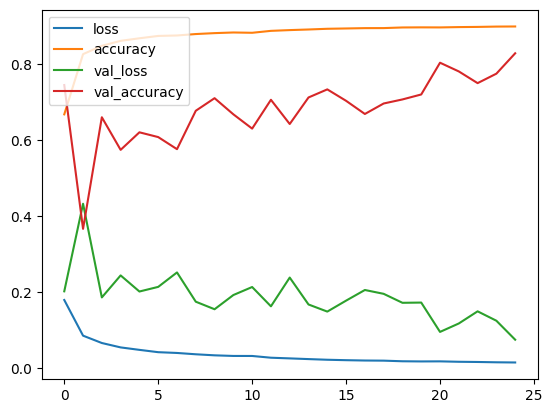

In [43]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.

plt.plot(unet_hist.history['loss'], label = 'loss')
plt.plot(unet_hist.history['accuracy'], label = 'accuracy')
plt.plot(unet_hist.history['val_loss'], label = 'val_loss')
plt.plot(unet_hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')
plt.show()


## Step 7. 결과 확인

### 문제 31. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [44]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.

res = model_unet.predict(test_images_small[1:2])


2023-10-12 19:21:40.279832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


### 문제 32. test_images[1], test_mattes[1]를 width 방향으로 결합하여 plt로 출력하세요.

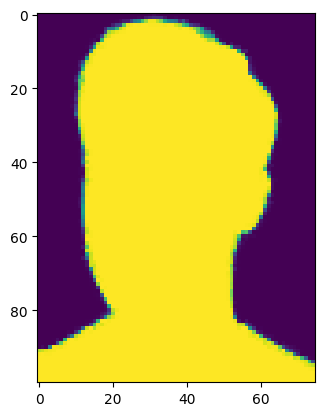

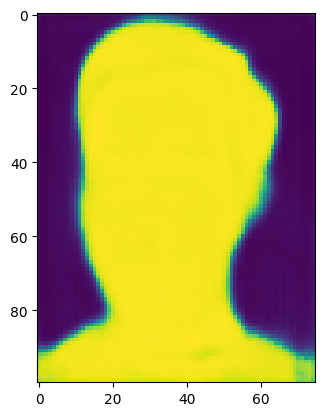

In [45]:
# test_mattes[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(test_mattes_small[1])
plt.show()
plt.imshow(res[0])
plt.show()


### 문제 33. res에 0.5의 값을 기준으로 0과 1로 2원화 시키고 다시 문제 32처럼 출력해보세요.

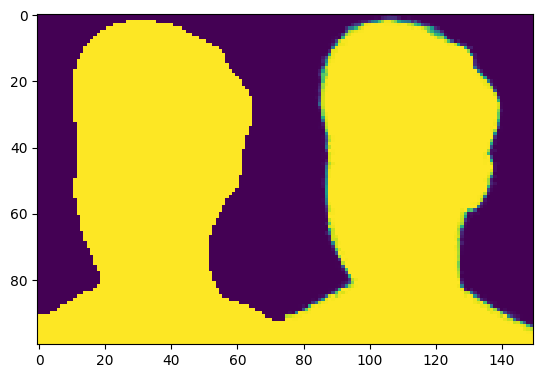

In [46]:
# res를 0.5기준으로 0,1의 값으로 이원화 시킨 뒤 문제 32처럼 출력하는 코드를 작성하세요.

imgs = np.concatenate([(res > 0.5).astype(np.float64).reshape(100, 75, 1), test_mattes_small[1]]).reshape(2, -1, 75, 1).transpose(1, 0 ,2, 3).reshape(100, -1)
plt.imshow(imgs)
plt.show()

### 문제 34. 5장의 test_images를 모델에 넣은 뒤 결과를 문제 32 방식으로 비교하세요.

1/1 [==============================] - 2s 2s/step


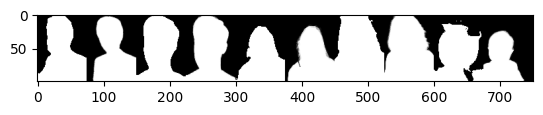

In [47]:
# 5장의 이미지를 모델에 넣고 결과를 32번과 같은 방식으로 비교하는 코드를 작성하세요
five = (model_unet.predict(test_images_small[:5]) > 0.5).astype(np.float64)
plt.imshow(np.concatenate([five, test_mattes_small[:5]], axis = 2).transpose(1, 0, 2, 3).reshape(100, -1), cmap = 'gray')
plt.show()


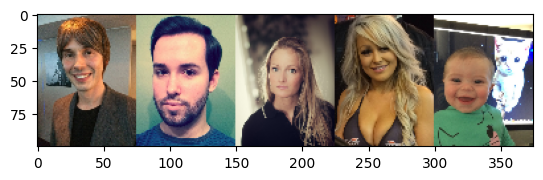

In [48]:
plt.imshow(test_images_small[:5].transpose(1, 0, 2, 3).reshape(100, -1, 3))
plt.show()

### 문제 35. test_images[1]과 res를 곱한뒤 plt에 출력해보세요.

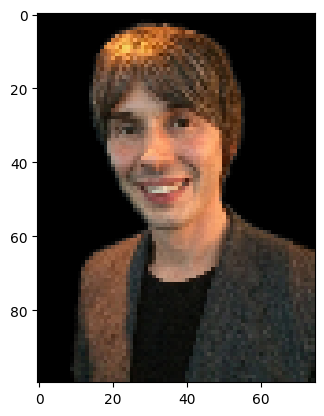

1/1 [==============================] - 0s 23ms/step


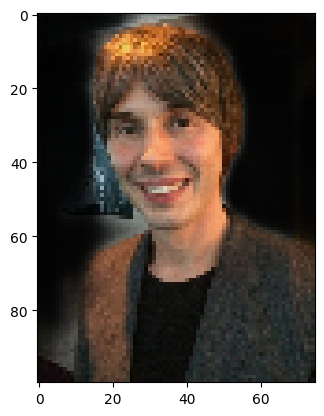

In [49]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지워보세요

plt.imshow(test_images_small[0] * test_mattes_small[0].reshape(100, 75, 1))
plt.show()

plt.imshow(test_images_small[0] * model_unet.predict(test_images_small[0:1]).reshape(100, 75, 1))
plt.show()



## Step 8. 모델 저장 및 로드, 다운

### 문제 36. 모델을 저장하세요.

In [50]:
# 모델을 저장하는 코드를 작성하세요.

model_unet.save('model/part2_ch02.h5')

### 문제 37. 모델 파일을 새로운 모델에 로드하세요.

In [51]:
# 모델을 로드하는 코드를 작성하세요.

load_model_unet = keras.models.load_model('model/part2_ch02.h5')


### 문제 38. 로드한 모델을 test 데이터로 평가해보세요.


In [52]:
# 로드한 모델을 test 데이터로 평가해보세요.

loss, acc = load_model_unet.evaluate(test_images_small, test_mattes_small)
print(loss, acc)

2023-10-12 19:21:46.853598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 329ms/step - loss: 0.0747 - accuracy: 0.8293
0.07474375516176224 0.8293004631996155


### 문제 39. 모델을 내 컴퓨터에 저장해보세요

In [53]:
# 모델을 내 컴퓨터에 저장해보세요.